# Disclaimer / Note to Evaluator
This needs to be run using a python3 interpreter. numpy, scipy, and matplotlib are all dependencies.

I definetly did not comment my code enough, it's really patchy actually :( I really hope the solutions are clear enough that it doesn't impede your understanding of my code.


# Question 7.1
Both parts (a) and (b) are complete.

In [21]:
"""Horner's Rule Polynomial Calculation."""

import numpy as np


def horner(degree, coeffs, t):
    """Apply the horner algorithm to a polynomial at t.
    
    Args:
        degree: Degree of the polynomial.
        coeffs: The coefficients of the polynomial.
        t: The value of the independent variable we evaluate the function at.
    """
    b = float(coeffs[degree])

    for i in reversed(range(degree)):
        b = coeffs[i] + b * t

    return b


def evaluate(degree, coeffs, t=None, a=None, b=None, evaluate='function'):
    """
    Wrapper of the horner algorithm to allow the computation of the
    function as is, or its derivative at t, or its definite integral with
    bounds (b, a).
    """
    coeffs = np.array(coeffs)
    
    if evaluate == 'function' and t is not None:
        return horner(degree, coeffs, t)
    
    elif evaluate == 'derivative' and t is not None:
        # Do the derivative on the coefficients.
        for i in range(degree):
            coeffs[i] = float(coeffs[i + 1]) * (i + 1)
        
        return horner(degree - 1, coeffs[:degree], t)
    
    elif evaluate == 'integral' and a is not None and b is not None:
        # Integrate the coefficients.
        new_coeffs = np.zeros(degree + 2)
        
        for i in reversed(range(1, degree + 2)):
            new_coeffs[i] = float(coeffs[i - 1]) / i
        
        at_a = horner(degree + 1, new_coeffs, a)
        at_b = horner(degree + 1, new_coeffs, b)
        return at_a - at_b
    
    else:
        return "You messed up."


# Test case.
print(evaluate(2, np.array([0, 2, 1]), t=2))
print(evaluate(2, np.array([0, 2, 1]), t=2, evaluate='derivative'))
print(evaluate(1, np.array([2, 2]), a=2, b=0, evaluate='integral'))

8.0
6.0
8.0


# Question 7.2

(a) Write a routine for computing the Newton polynomial interpolant for a given set of data points, and a second routine for evaluating the Newton interpolant at a given argument value using Horner’s rule.

(b) Write a routine for computing the new Newton polynomial interpolant when a new data point is added.

(c) If your programming language supports recursion, write a recursive routine that implements part a by calling your routine for part b recursively. Compare its performance with that of your original implementation.

In [120]:
"""Newton Polynomial Interpolation Problem."""

import numpy as np
import unittest
import timeit


class NewtonInterpolant(object):
    """Big dumb data structure for doing this problem."""
    def __init__(self):
        self.data = []
        self.n = 0
        self.A = None
        self.t = None
        self.y = None
        self.x = None

    def interpolant_from_points(self, data):
        self.data = data
        return self.calculate_interpolant()
    
    def interpolant_from_points_rec(self, data):
        for datapoint in data:
            interpolant = self.add(datapoint)
        return interpolant
    
    def calculate_interpolant(self):
        _data = np.array(self.data)
        self.n = _data.shape[0]
        self.A = np.zeros([self.n, self.n])
        self.A[:, 0] = np.ones([self.n])
        for i in range(1, self.n):
            for j in range(1, self.n):
                self.A[i, j] = self.A[i, j-1] * (_data[i, 0] - _data[j-1, 0])
        
        self.t = np.array(_data[:, :1])
        self.y = np.array(_data[:, 1:])
        self.x = np.linalg.solve(self.A, self.y)
        return self.x
    
    def psi(self, t, i):
        result = 1
        for j in range(i - 1):
            result *= (t - self.t[j])
        return result
    
    def add(self, datapoint):
        self.data.append(datapoint)
        _data = np.array(self.data)

        self.t = np.array(_data[:, :1])
        self.y = np.array(_data[:, 1:])
        
        n = len(self.data)
        if n == 1:
            self.n = n
            self.x = np.array(self.y)
        else:
            p = self.evaluate_horner(self.t[-1])
            self.n = n
            self.x = np.append(self.x, (self.y[-1] - p) / self.psi(self.t[-1], self.n))
        return self.x
            

    def evaluate_horner(self, t):
        """Use horner rule to evaluate the interpolant polynomial at point t."""
        result = self.x[0]
        cumul = 1
        for i in range(1, self.n):
            cumul *= (t - self.t[i - 1])
            result += cumul * self.x[i]

        return float(result)
    
    
class TestInterpolant(unittest.TestCase):
    """Unit tests to make it work and stop myself from going insane."""
    def setUp(self):
        self._t = NewtonInterpolant()
                
    def test_newton_interpolan(self):
        self._t.interpolant_from_points([[-1, 1], [0,0], [1, 1]])
        np.testing.assert_array_equal(self._t.A, np.matrix("1 0 0; 1 1 0; 1 2 2"))
        np.testing.assert_array_equal(self._t.t, np.matrix("-1; 0; 1"))
        np.testing.assert_array_equal(self._t.y, np.matrix("1; 0; 1"))
        np.testing.assert_array_equal(self._t.x, np.matrix("1; -1; 1"))
    
    def test_horner_evaluation(self):
        self._t.interpolant_from_points([[-1, 1], [0,0], [1, 1]])
        self.assertEqual(self._t.evaluate_horner(1), 1)
        self.assertEqual(self._t.evaluate_horner(-1), 1)
    
    def test_adding_new_data(self):
        self._t.interpolant_from_points([[-1, 1], [0,0], [1, 1]])
        self._t.add([2, 4])
        np.testing.assert_array_equal(self._t.t, np.matrix("-1; 0; 1; 2"))
        np.testing.assert_array_equal(self._t.y, np.matrix("1; 0; 1; 4"))
        # Should give the same result as before:
        self.assertEqual(self._t.evaluate_horner(1), 1)
        self.assertEqual(self._t.evaluate_horner(-1), 1)
    
    def test_adding_new_data(self):
        self._t.add([-2, -27])
        self.assertEqual(-27, self._t.evaluate_horner(1))
        self._t.add([0, -1])
        self.assertEqual(self._t.evaluate_horner(1), 12)
        
    def test_adding_recursive_method(self):
        self._t.interpolant_from_points_rec([[-2, -27], [0, -1], [1, 0]])
        x = self._t.evaluate_horner(1)
        self.assertEqual(x, 0)
        

# Part A
print("Our initial data is [-2, -27], [0, -1]")
evaluator = NewtonInterpolant()
print("The interpolant is\n{}\n".format(evaluator.interpolant_from_points([[-2, -27], [0, -1]])))
print("The value at 3 is {}\n\n".format(evaluator.evaluate_horner(3)))

# Part B
print("We add the data point (2, 4)")
print("The interpolant is\n{}\n".format(evaluator.add([2, 4])))

# Part C
evaluator_2 = NewtonInterpolant()
evaluator_2.interpolant_from_points_rec([[-2, -27], [0, -1], [1, 0]])
print(evaluator_2.evaluate_horner(1))

# Timing:
def help_rec():
    data = np.random.rand(5, 2)
    x = NewtonInterpolant()
    x.interpolant_from_points_rec(data)

def help_int():
    data = np.random.rand(5, 2)
    x = NewtonInterpolant()
    x.interpolant_from_points(data)
    
print(timeit.timeit("help_rec()", setup="from __main__ import help_rec", number=1000))
print(timeit.timeit("help_int()", setup="from __main__ import help_int", number=1000))


unittest.main(argv=['first-arg-is-ignored'], exit=False)

Our initial data is [-2, -27], [0, -1]
The interpolant is
[[-27.]
 [ 13.]]

The value at 3 is 38.0


We add the data point (2, 4)
The interpolant is
[ 90.    13.   -10.75]

0.0


....

0.23673461700673215
0.06760287699580658



----------------------------------------------------------------------
Ran 4 tests in 0.006s

OK


# Question 7.3
(a) Write the system of equations de-
rived in Example 7.6 in matrix form.
(b) Use a library routine, or one of your own
design, to solve the resulting 8×8 linear system
using the data given in Example 7.1.
(c) Plot the resulting natural cubic spline,
along with the given data points. Also plot the
first and second derivatives of the cubic spline
and confirm that all of the required conditions
are met.

The alpha beta matrix is 
[[  1   1   1   1   0   0   0   0]
 [  1   2   4   8   0   0   0   0]
 [  0   0   0   0   1   2   4   8]
 [  0   0   0   0   1   3   9  27]
 [  0   1   4  12   0  -1  -4 -12]
 [  0   0   2  12   0   0  -2 -12]
 [  0   0   2   6   0   0   0   0]
 [  0   0   0   0   0   0   2  18]]
The output matrix is
 [[ 1]
 [-1]
 [-1]
 [ 4]
 [ 0]
 [ 0]
 [ 0]
 [ 0]]
The alpha betas (i.e. a1, a2, a3, a4, b1, b2, b3, b4) are
[[  3.  ]
 [  1.5 ]
 [ -5.25]
 [  1.75]
 [ 31.  ]
 [-40.5 ]
 [ 15.75]
 [ -1.75]]


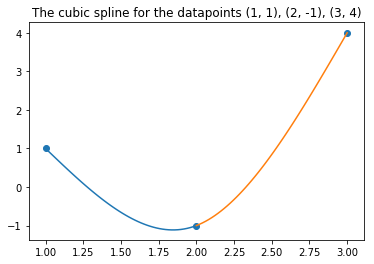

In [77]:
%matplotlib inline
import numpy as np
import pylab as plt


# PART A
def cubic_spline(t1, t2, t3, y1, y2, y3):
    #               a1  a2  a3             a4    b1  b2      b3       b4
    eq1 = np.array([1, t1, t1 ** 2,     t1 ** 3, 0,  0,       0,            0])
    eq2 = np.array([1, t2, t2 ** 2,     t2 ** 3, 0,  0,       0,            0])
    eq3 = np.array([0,  0,       0,           0, 1, t2, t2 ** 2,      t2 ** 3])
    eq4 = np.array([0,  0,       0,           0, 1, t3, t3 ** 2,      t3 ** 3])
    eq5 = np.array([0,  1,  2 * t2, 3 * t2 ** 2, 0, -1, -2 * t2, -3 * t2 ** 2])
    eq6 = np.array([0,  0,       2,      6 * t2, 0,  0,      -2,      -6 * t2])
    eq7 = np.array([0,  0,       2,      6 * t1, 0,  0,       0,            0])
    eq8 = np.array([0,  0,       0,           0, 0,  0,       2,       6 * t3])
    
    out = np.array([[y1], [y2], [y2], [y3], [0], [0], [0], [0]])
    return np.matrix([eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8]), np.matrix(out)

def plot_helper(t, x1, x2, x3, x4):
    return float(x1 + x2 * t + x3 * t**2 + x4 * t**3)

eqs = cubic_spline(1, 2, 3, 1, -1, 4)
# PART A
print("The alpha beta matrix is \n{}\nThe output matrix is\n {}".format(eqs[0], eqs[1]))

# PART B
alpha_beta = np.linalg.solve(eqs[0], eqs[1])
print("The alpha betas (i.e. a1, a2, a3, a4, b1, b2, b3, b4) are\n{}".format(alpha_beta))

plt.scatter([1, 2, 3], [1, -1, 4])

x1 = np.linspace(1, 2, 50)
y1 = [plot_helper(t, *alpha_beta[:4]) for t in x1]
x2 = np.linspace(2, 3, 50)
y2 = [plot_helper(t, *alpha_beta[4:]) for t in x2]

plt.plot(x1, y1)
plt.plot(x2, y2)
plt.title("The cubic spline for the datapoints (1, 1), (2, -1), (3, 4)")
plt.show()


# Question 7.4

The cubic spline seems to give better data between the data points, it oscilates much less. This is a result of the fact that each interval has its own set of polynomial coefficients. This means the data can match not only the data, but certain properties like matching the derivatives and curvature accross knots means we have a generally more smooth curve.

From a high level perspective, we can think of it as we are effectively fitting to more features of the data in the Cubic Spline case by making assumptions about derivatives of the data at the data points. This leaves us with a more reasonable.

_Might piecewise linear interpolation be a better choice for these particular data? Why?_

Well the real answer is it depends. If we believe the data has a simpler underlying representation (i.e. we know it's like a second order polynomial, then using a piecewise polynomial will reduce a lot of the parameters of the resulting functions over the intervals. This _might_ result in more accurate behaviour, but it will likely introduce discontinuities in the derivatives and the curvature, which might be unrealistic.

So if it is known to be a lower order polynomial representation, then the piecewise polynomial saves us some computation. If we want the smootheness properties in the first and second derivatives, then we need to use the Cubic Spline at the expense of a more computationally expensive solution.

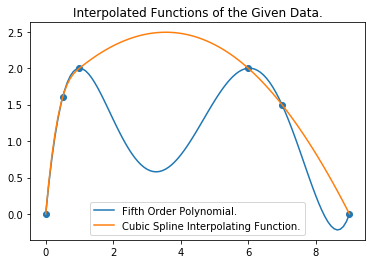

In [134]:
import numpy as np
import pylab as plt
from scipy.interpolate import KroghInterpolator, CubicSpline

t = np.array([0.0, 0.5, 1.0, 6.0, 7.0, 9.0])
y = np.array([0.0, 1.6, 2.0, 2.0, 1.5, 0.0])
plt.scatter(t, y)

# PART A
f = KroghInterpolator(t, y)
x = np.linspace(0, 9, 100)
out = [f(i) for i in x]
plt.plot(x, out, label="Fifth Order Polynomial.")
plt.title("Interpolated Functions of the Given Data.")

# PART B
spline = CubicSpline(t, y)
y = [spline(i) for i in x]

plt.plot(x, y, label="Cubic Spline Interpolating Function.")

plt.legend(loc="best")


# Question 7.5

The cubic spline is much more accurate over most of the domain.

However, over the range $t=[0,1]$ we have a superior mean squared error in the polynomial approximation.

Mean squared error of the polynomial on range t=[0,1] is 0.01757489798099086
Mean squared error of the cubic spline on range t=[0,1] is 0.01937290945217515


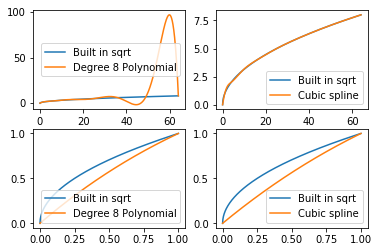

In [157]:
from math import sqrt
import numpy as np
import pylab as plt
from scipy.interpolate import KroghInterpolator, CubicSpline

t = np.array([0, 1, 4, 9, 16, 25, 36, 49, 64])
y = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])

## Part A
x = np.linspace(0, 64, num=1000)
x2 = np.linspace(0, 1, num=1000)
y1 = [sqrt(i) for i in x]
y1_2 = [sqrt(i) for i in x2]
fig, ax = plt.subplots(2, 2)
ax[0][0].plot(x, y1, label="Built in sqrt")
ax[1][0].plot(x2, y1_2, label="Built in sqrt")

f2 = KroghInterpolator(t, y)
y2 = [f2(i) for i in x]
y2_2 = [f2(i) for i in x2]
ax[0][0].plot(x, y2, label="Degree 8 Polynomial")
ax[1][0].plot(x2, y2_2, label="Degree 8 Polynomial")

ax[0][0].legend(loc="best")
ax[1][0].legend(loc="best")

## Part B
ax[0][1].plot(x, y1, label="Built in sqrt")
ax[1][1].plot(x2, y1_2, label="Built in sqrt")

f3 = CubicSpline(t, y)
y3 = [f3(i) for i in x]
y3_2 = [f3(i) for i in x2]

ax[0][1].plot(x, y3, label="Cubic spline")
ax[1][1].plot(x2, y3_2, label="Cubic spline")

ax[0][1].legend(loc="best")
ax[1][1].legend(loc="best")

## Errors
mse_poly = ((np.array(y1_2) - np.array(y2_2)) ** 2).mean()
print("Mean squared error of the polynomial on range t=[0,1] is {}".format(mse_poly))
mse_cubic = ((np.array(y1_2) - np.array(y3_2)) ** 2).mean()
print("Mean squared error of the cubic spline on range t=[0,1] is {}".format(mse_cubic))


# Question 8.1(a,b)

$$\int_0^1\frac{4}{1+x^2}dx = \pi$$
(a) Midpoint, trapezoid, Simpson composite quadrature rules to compute the approximate value for $\pi$ for various step sizes h. 

The graphs are bellow.

Work to find the representative equation is done in the following cell.

Yes there is a point after which there is no improvement, you can uncomment the last couple lines and wait and see, it's likely due to machine precision and cancelation errors. The accuracy of the trapezoid and midpoint rules are much worse than that of the Simpson's rule implementation, as expected, since they have second order error terms while the Simpson's rule has a fourth order error term.

(b) Implement Romberg integration and repeat part a using it.

/home/mw/Documents/NUM_METHODS/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


[8.29628877e-02 5.93075657e-05 3.14159252e+00]


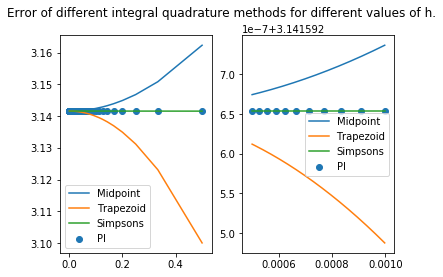

In [219]:
%matplotlib inline
from math import pi
import numpy as np
import pylab as plt


def midpoint_rule(f, x):
    result = 0
    for i in range(1, len(x)):
        a = x[i-1]
        b = x[i]
        result += (b - a) * f((a + b) / 2)
    return result


def trapezoid_rule(f, x):
    result = 0
    for i in range(1, len(x)):
        a = x[i-1]
        b = x[i]
        result += ((b - a) / 2) * (f(a) + f(b))
    return result


def simpsons_rule(f, x):
    result = 0
    for i in range(1, len(x)):
        a = x[i-1]
        b = x[i]
        result += ((b - a) / 6) * (f(a) + 4 * f((a + b) / 2) + f(b))
    return result


midpoint_approximations = []
trapezoid_approximations = []
simpsons_approximations = []
hs = []
for steps in range(3, 2004, 1):
    h = 1 / (steps - 1)
    hs.append(h)
    x = np.linspace(0, 1, num=steps)
    midpoint_approximations.append(midpoint_rule(fx, x))
    trapezoid_approximations.append(trapezoid_rule(fx, x))
    simpsons_approximations.append(simpsons_rule(fx, x))

hs = np.array(hs)
midpoint_approximations = np.array(midpoint_approximations)
trapezoid_approximations = np.array(trapezoid_approximations)
simpsons_approximations = np.array(simpsons_approximations)

fig, ax = plt.subplots(1, 2)
ax[0].plot(hs, midpoint_approximations, label="Midpoint")
ax[0].plot(hs, trapezoid_approximations, label="Trapezoid")
ax[0].plot(hs, simpsons_approximations, label="Simpsons")
ax[0].scatter(hs, pi * np.ones([len(hs)]), label="PI")
ax[0].legend(loc="best")

ax[1].plot(hs[1000:], midpoint_approximations[1000:], label="Midpoint")
ax[1].plot(hs[1000:], trapezoid_approximations[1000:], label="Trapezoid")
ax[1].plot(hs[1000:], simpsons_approximations[1000:], label="Simpsons")
ax[1].scatter(hs[1000::100], pi * np.ones([len(hs)])[1000::100], label="PI")
ax[1].legend(loc="best")

fig.suptitle("Error of different integral quadrature methods for different values of h.")
fig.show()



def look_for_end_of_improvement_midpoint():
    steps = 2000
    x = np.linspace(0, 1, num=steps)
    measure = midpoint_rule(fx, x)
    diff = measure - pi
    prev_diff = 1.0
    while diff > 0 and diff < prev_diff:
        steps += 10000
        h = 1 / (steps - 1)
        x = np.linspace(0, 1, num=steps)
        measure = midpoint_rule(fx, x)
        prev_diff = diff
        diff = measure - pi
    return steps


def look_for_end_of_improvement_trapezoid():
    steps = 2000
    x = np.linspace(0, 1, num=steps)
    measure = trapezoid_rule(fx, x)
    diff = measure - pi
    prev_diff = -1.0
    while diff < 0 and diff > prev_diff:
        steps += 10000
        h = 1 / (steps - 1)
        x = np.linspace(0, 1, num=steps)
        measure = trapezoid_rule(fx, x)
        prev_diff = diff
        diff = measure - pi
    return steps


# Uncomment these and wait if you're really patient
#look_for_end_of_improvement_midpoint()
#look_for_end_of_improvement_trapezoid()

In [224]:
# Next part of part (a) i.e. finding a function approximation.
# I want to fit a function to my midpoint, trapezoid and simpsons implementations.
# Then I can do part (b).
# THIS IS NOT COMPLETE, COME BACK TO IT.

pmid = np.polyfit(hs, midpoint_approximations, deg=2)
print(pmid)


[8.29628877e-02 5.93075657e-05 3.14159252e+00]


# Question 8.5

Each of the following integrands is defined piecewise over the indicated interval. Use
an adaptive quadrature routine to evaluate
each integral over the given interval. For the
same overall accuracy requirement, compare
the cost of evaluating the integral using a single subroutine call over the whole interval with
the cost when the routine is called separately
in each appropriate subinterval. Experiment
with both loose and strict error tolerances.

(a) $f(x)= \left\{ \begin{array}{lr}0 & 0 \leq x \leq 0.3 \\ 1 & 0.3 \leq x \leq 1 \end{array}\right\}$

(b) $f(x)= \left\{ \begin{array}{lr}\frac{1}{x+2} & 0 \leq x \leq e-2 \\ 0 & e-2 \leq x \leq 1 \end{array}\right\}$

(c) $f(x)= \left\{ \begin{array}{lr}e^x & -1 \leq x \leq 0 \\ e^{1-x} & 0 \leq x \leq 2 \end{array}\right\}$

(d) $f(x)= \left\{ \begin{array}{lr}e^{10x} & -1 \leq x \leq 0.5 \\ e^{10(1-x)} & 0.5 \leq x \leq 1.5 \end{array}\right\}$


The cost of evaluating over each subinterval has a huge impact on execution time. There is an order of magnitude difference between the split interval and the full interval evaluation method. The drop in error tolerances does not really impact the time of evaluation of the split interval implementation, but it does significantly impact that of the full interval. For every two decimal places of error tolerance, the time of completion is cut in half.

In [267]:
# The way I understand this question, I'm pretty sure it should be okay to use
# a library routine. I use the numpy quad call, and adjust its error tolerances
# and different approaches as stated in the problem description.
import math
import scipy as sp
import timeit


def f1(x):
    if 0 <= x <= 0.3:
        return 0
    elif 0.3 <= x <= 1:
        return 1
    

def f2(x):
    if 0 <= x <= math.e - 2:
        return 1 / (x + 2)
    elif math.e - 2 <= x <= 1:
        return 0


def f3(x):
    if -1 <= x <= 0:
        return math.exp(x)
    elif 0 <= x <= 2:
        return math.exp(1 - x)


def f4(x):
    if -1 <= x <= 0.5:
        return math.exp(10 * x)
    elif 0.5 <= x <= 1.5:
        return math.exp(10 * (1 - x))

def evaluate_integral(error=1.49e-08):
    # Use an adaptive quadrature routine to evaluate each integral over the given interval.
    print("Adaptive quad results.")
    res1 = sp.integrate.quad(f1, 0, 1, epsabs=error)
    print("The integral for a is {} with an estimated absolute error of {}.".format(res1[0], res1[1]))

    res2 = sp.integrate.quad(f2, 0, 1, epsabs=error)
    print("The integral for b is {} with an estimated absolute error of {}.".format(res2[0], res2[1]))

    res3 = sp.integrate.quad(f3, -1, 2, epsabs=error)
    print("The integral for c is {} with an estimated absolute error of {}.".format(res3[0], res3[1]))

    res4 = sp.integrate.quad(f4, -1, 1.5, epsabs=error)
    print("The integral for d is {} with an estimated absolute error of {}.\n".format(res4[0], res4[1]))

# For the same overall accuracy requirement, compare the cost
# of evaluating the integral using a single subroutine call 
# over the whole interval with the cost when the routine is 
# called separately in each appropriate subinterval.

def timing(part, fn, a, b, m, error=1.49e-08):
    full_range = timeit.timeit("sp.integrate.quad({}, {}, {}, epsabs={})".format(fn, a, b, error),
                               setup="import scipy as sp;from __main__ import {}".format(fn),
                               number=1000)
    split_range = timeit.timeit("sp.integrate.quad({0}, {1}, {3}, epsabs={4})"
                                "+ sp.integrate.quad({0}, {3}, {2}, epsabs={4})".format(fn, a, b, m, error),
                                setup="import scipy as sp;from __main__ import {}".format(fn),
                                number=1000)

    print("({}) Total time (distinct ranges, full range) for 1000 evaluations are ({}, {}).".format(part,
                                                                                                         split_range,
                                                                                                         full_range))

# Run quad results.
evaluate_integral()

print("Cost analysis.")
# Run timings for split vs full range.
timing("a", "f1", "0", "1", "0.3")
timing("b", "f2", "0", "1", "{}".format(math.e - 2))
timing("c", "f3", "-1", "2", "0")
timing("d", "f4", "-1", "1.5", "0.5")


# Run Timings with loose error tolerances.
print("\nLooser error tolerance")
evaluate_integral(0.0001)

print("Cost analysis with 0.0001 error tolerance.")
timing("a", "f1", "0", "1", "0.3", 0.0001)
timing("b", "f2", "0", "1", "{}".format(math.e - 2), 0.0001)
timing("c", "f3", "-1", "2", "0", 0.0001)
timing("d", "f4", "-1", "1.5", "0.5", 0.0001)

print("\nCost analysis with 0.01 error tolerance.")
timing("a", "f1", "0", "1", "0.3", 0.01)
timing("b", "f2", "0", "1", "{}".format(math.e - 2), 0.01)
timing("c", "f3", "-1", "2", "0", 0.01)
timing("d", "f4", "-1", "1.5", "0.5", 0.01)


Adaptive quad results.
The integral for a is 0.7000000000000001 with an estimated absolute error of 7.771561172376097e-16.
The integral for b is 0.306852820409752 with an estimated absolute error of 7.716327798945599e-09.
The integral for c is 2.982522946116156 with an estimated absolute error of 3.239049028991303e-10.
The integral for d is 29.681953485822337 with an estimated absolute error of 3.178918106527817e-08.

Cost analysis.
(a) Total time (distinct ranges, full range) for 1000 evaluations are (0.02564446699398104, 0.16005986800882965).
(b) Total time (distinct ranges, full range) for 1000 evaluations are (0.038871040000231005, 0.7652727720123949).
(c) Total time (distinct ranges, full range) for 1000 evaluations are (0.04008647199952975, 0.283436026002164).
(d) Total time (distinct ranges, full range) for 1000 evaluations are (0.04155611000896897, 0.3632881509984145).

Looser error tolerance
Adaptive quad results.
The integral for a is 0.7000000000000001 with an estimated abso

# Question 8.7

Smooth plot of 
$$C(x) = \int_0^x cos(\frac{\pi t^2}{2})dt$$
and
$$S(x) = \int_0^x sin(\frac{\pi t^2}{2})dt$$

The left plot is 

Text(0.5,0.98,'The values of the fresnel coeficients over the range $0<=x<=5$')

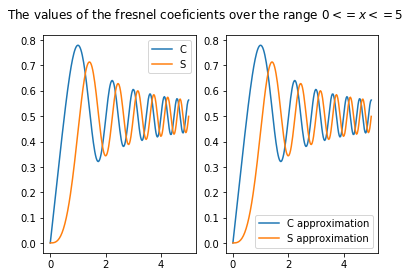

In [289]:
import scipy as sp
import numpy as np
import pylab as plt
import math


def C_internal(t):
    return math.cos(math.pi * t**2 / 2)

def S_internal(t):
    return math.sin(math.pi * t**2 / 2)


x = np.linspace(0, 5, num=200)
cs = []
cs_aprox = []
ss = []
ss_aprox = []
for i in x:
    s, c = sp.special.fresnel(i)
    cs.append(c)
    cs_aprox.append(sp.integrate.quad(C_internal, 0, i)[0])
    ss.append(s)
    ss_aprox.append(sp.integrate.quad(S_internal, 0, i)[0])

fig, ax = plt.subplots(1, 2)
ax[0].plot(x, cs, label="C")
ax[0].plot(x, ss, label="S")
ax[0].legend(loc="best")

ax[1].plot(x, cs_aprox, label="C approximation")
ax[1].plot(x, ss_aprox, label="S approximation")
ax[1].legend(loc="best")
fig.suptitle(r"The values of the fresnel coeficients over the range $0<=x<=5$")


# Question 8.11
Evaluation of the double integral
$$\Phi(\hat{x}, \hat{y}) = \int_{-1}^{1} \int_{-1}^{1}\frac{dx  dy}{\sqrt{(\hat{x}-x)^2+(\hat{y}-y)^2}}$$

such that it is smooth over the interval $2<=\hat{x}<=10, 2<=\hat{y}<=10$.

<span style="color:blue">Pretty darn smooth if you ask me :)</span>

Text(0.5,0.98,'Electrostatic potential outside a uniform charge distribution.')

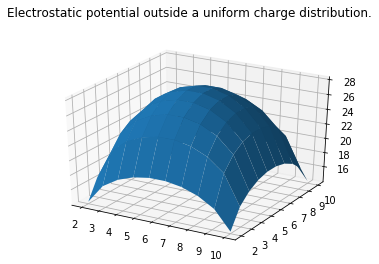

In [309]:
from math import sqrt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def psi(x_hat, y_hat):
    return lambda y, x: 1 / sqrt((x_hat - x)**2 + (y_hat - y)**2)


size = 10
x_inputs = np.zeros([size, size])
y_inputs = np.zeros([size, size])
results = np.zeros([size, size])
x_h = np.linspace(2, 10, num=size)
y_h = np.linspace(2, 10, num=size)

for i in range(size):
    x_inputs[i, :] = x_h[i]
    for j in range(size):
        y_inputs[i, j] = y_h[j]
        results[i, j] = sp.integrate.dblquad(psi(x_h[i], y_h[j]), 2, 10, lambda x: 2, lambda x: 10)[0]

fig = plt.figure()
ax = fig.gca(projection='3d')

X, Y = np.meshgrid(x_h, y_h)
ax.plot_surface(X, Y, results)
fig.suptitle("Electrostatic potential outside a uniform charge distribution.")

# Question 8.16(a,b,d)
For each of the following methods for estimating the derivative, compute the derivative of
the original data and also experiment with randomly perturbing the y values to determine
the sensitivity of the resulting derivative estimates. For each method, comment on both
the reasonableness of the derivative estimates and their sensitivity to perturbations. Note
that the data are monotonically increasing, so
one might expect the derivative always to be
positive.
* (a) For $n = 0, 1, . . . , 5$, fit a polynomial of degree n by least squares to the data, then differentiate the resulting polynomial and evaluate the derivative at each of the given t values.
* (b) Interpolate the data with a cubic spline, differentiate the resulting piecewise cubic polynomial, and evaluate the derivative at each of the given t values (some spline routines pro vide the derivative automatically, but it can be done manually if necessary).
* (d ) Interpolate the data with a monotonic Hermite cubic, differentiate the resulting piecewise cubic polynomial, and evaluate the derivative at each of the given t values

_Part A_
Run the code to see the results bellow. There are a few things to keep in mind, if this is noisy data, then the degree 1 and 2 polynomials are not too bad of a fit, although the degree 2 polynomial is much more suceptible to noise, then 1st degree one is simply not responsive. The degree 3 polynomial looks pretty good, but it breaks down badly with noise. The degree 4 and 5 polynomial don't appear to work very well at all, probably because in order to fit all of the points there is a great deal of oscilation in between the actuall data points. This will make the slopes really big at the data, and sometimes even negative, which as stated in the problem is probably wrong considering the data.


_Part B_
The cubic spline interpretation is good, appart from the first derivative, which is negative. This is probably because it can get a much better match with the aggressive changes in derivative at the next couple of points. That being said, this model is appropriate if we have a fairly high certainty that this data was unpertubed by noise, but if it is a noisy measure then we will probably have some issues. The main thing to note is how the cubic spline derivative behaves in the presence of noise (not well).

_Part D_
I wasn't able to use the Hermite monotithic spline, but I was able to use a library monotithic spline. This one looks really representative of the data, especially if we are assuming monotonically increasing function. It also behaves very well in the presence of a reasonable amount of noise.

Polynomial Fit Derivative Estimation.
-------------------------------------
t : [0. 1. 2. 3. 4. 5.]
y : [1.  2.7 5.8 6.6 7.5 9.9]
Degree 1
--------
                         y' : [1.70571429 1.70571429 1.70571429 1.70571429 1.70571429 1.70571429]
y' + 0.001 var Gaussian Noise: [1.70571429 1.70571429 1.70571429 1.70571429 1.70571429 1.70571429]
y' +  0.01 var Gaussian Noise: [1.70571429 1.70571429 1.70571429 1.70571429 1.70571429 1.70571429]
y' +  0.1 var Gaussian Noise: [1.70571429 1.70571429 1.70571429 1.70571429 1.70571429 1.70571429]

Degree 2
--------
                         y' : [2.17892857 1.98964286 1.80035714 1.61107143 1.42178571 1.2325    ]
y' + 0.001 var Gaussian Noise: [2.17899675 1.98981833 1.80041535 1.61127013 1.42187173 1.23225952]
y' +  0.01 var Gaussian Noise: [2.17922779 1.98880079 1.80086275 1.60715444 1.4229802  1.23075141]
y' +  0.1 var Gaussian Noise: [2.13054726 1.99272796 1.78354047 1.59984853 1.428416   1.22434788]

Degree 3
--------
                         y

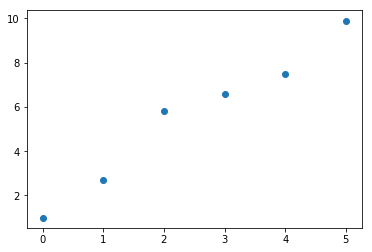

In [345]:
import numpy as np
import pylab as plt


t = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
y = np.array([1.0, 2.7, 5.8, 6.6, 7.5, 9.9])
plt.scatter(t, y)

# Part A
print("Polynomial Fit Derivative Estimation.\n-------------------------------------")
print("t : {}".format(t))
print("y : {}".format(y))
for n in range(1, 6):
    print("Degree {}\n--------".format(n))
    # Fit a polynomial of order n to the data.
    p = np.poly1d(np.polyfit(t, y, n))

    # Differentiate the polynomial.
    p_prime = np.polyder(p)
    
    # Calculate the derivative at each point.
    print("                         y' : {}".format(p_prime(t)))
    print("y' + 0.001 var Gaussian Noise: {}".format(p_prime(t + 0.001 * np.random.randn(6))))
    print("y' +  0.01 var Gaussian Noise: {}".format(p_prime(t + 0.01 * np.random.randn(6))))
    print("y' +  0.1 var Gaussian Noise: {}\n".format(p_prime(t + 0.1 *np.random.randn(6))))

# Part B
print("Cubic Spline Fit Derivative Estimation.\n-------------------------------------")
print("t : {}".format(t))
print("y : {}".format(y))
p_prime = sp.interpolate.CubicSpline(t, y).derivative()
print("                         y' : {}".format(p_prime.__call__(t)))
print("y' + 0.001 var Gaussian Noise: {}".format(p_prime.__call__(t + 0.001 * np.random.randn(6))))
print("y' +  0.01 var Gaussian Noise: {}".format(p_prime.__call__(t + 0.01 * np.random.randn(6))))
print("y' +  0.1 var Gaussian Noise: {}\n".format(p_prime.__call__(t + 0.1 * np.random.randn(6))))

# Part D
print("Monotithic Spline Fit Derivative Estimation.\n-------------------------------------")
print("t : {}".format(t))
print("y : {}".format(y))
p_prime = sp.interpolate.PchipInterpolator(t, y).derivative()
print("                         y' : {}".format(p_prime.__call__(t)))
print("y' + 0.001 var Gaussian Noise: {}".format(p_prime.__call__(t + 0.001 * np.random.randn(6))))
print("y' +  0.01 var Gaussian Noise: {}".format(p_prime.__call__(t + 0.01 * np.random.randn(6))))
print("y' +  0.1 var Gaussian Noise: {}\n".format(p_prime.__call__(t + 0.1 * np.random.randn(6))))

# TODO Questions
* <span style="color:blue">9.1</span>, 9.8

# Question 9.1

Population problem

$$y_1' = by_1-cy_1y_2$$
$$y_2' = -dy_2+cy_1y_2$$
With the parameter values $b = 1$,
$d = 10$, and $c = 1$, and initial conditions
$y_1 (0) = 0.5$ and $y_2 (0) = 1$ (the populations
are normalized, and we treat them as continuous variables), use a library routine to solve
this system numerically, integrating to t = 10.
Plot each of the two populations as a function
of time, and on a separate graph plot the trajectory of the point $(y_1 (t), y_2 (t))$ in the plane
as a function of time. The latter is sometimes
called a “phase portrait.” Give a physical interpretation of the behavior you observe. Can
you find nonzero initial populations such that
either of the populations eventually becomes
extinct?


Basically the physical representation is that the prey grows slowly, in a slightly exponential fashion when there are almost no predators. As soon as the prey population reaches a certain point, the predator population jumps dramatically and the prey population drops even more dramatically. We were able to kill off the predator by starting the predator population high and the prey population low. At one point the predator population becomes negative, which means there was extinction.

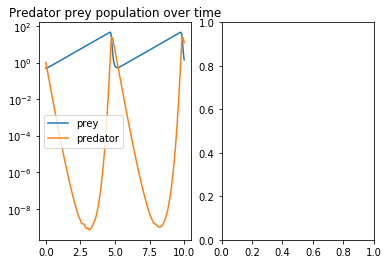

In [2]:
import scipy as sp
import numpy as np
import pylab as plt
import scipy.integrate


b = 1
c = 1
d = 10

def dY_dt(Y, t=0):
    return np.array([b * Y[0] - c * Y[0] * Y[1],
                    -d * Y[1] + c * Y[0] * Y[1]])


Y0 = np.array([0.5, 1])
t = np.linspace(0, 10, num=500)

Y = sp.integrate.odeint(dY_dt, Y0, t)
prey, predator = Y.T

fig, ax = plt.subplots(1, 2)
ax[0].semilogy(t, prey, label="prey")
ax[0].semilogy(t, predator, label="predator")
ax[0].legend(loc="best")
ax[0].set_title("Predator prey population over time")

# I don't know how to do this next part...
values  = np.linspace(0.3, 0.9, 5)
vcolors = plt.cm.autumn_r(np.linspace(0.3, 1., len(values)))


for v, col in zip(values, vcolors):
    Y0 = v * X_f1
    X = integrate.odeint( dX_dt, X0, t)
    p.plot( X[:,0], X[:,1], lw=3.5*v, color=col, label='X0=(%.f, %.f)' % ( X0[0], X0[1]) )

# Question 9.2
The Kermack-McKendrick model for the
course of an epidemic in a population is given
by the system of ODEs

$$y_1' = -cy_1y_2$$
$$y_2' = cy_1y_2-dy_2$$
$$y_3' = d y_2$$

where <span style="color:blue">$y_1$ represents susceptibles</span>, <span style="color:red">$y_2$ represents
infectives in circulation</span>, and <span style="color:green">$y_3$ represents infectives removed by isolation, death, or recovery and immunity</span>. The parameters c and d
represent the infection rate and removal rate,respectively. Use a library routine to solve this
system numerically, with the parameter values
$c = 1$ and $d = 5$, and initial values $y_1 (0) = 95,
y_2 (0) = 5, y_3 (0) = 0$. Integrate from $t = 0$ to
$t = 1$. Plot each solution component on the
same graph as a function of t. As expected
with an epidemic, you should see the number of infectives grow at first, then diminish to
zero. Experiment with other values for the parameters and initial conditions. Can you find
values for which the epidemic does not grow, or
for which the entire population is wiped out?


**The epidemic is stunted if the rate of death / imunization (i.e. $d$) is big enough relative to the infection rate, as seen in the second plot.. The entire population is infected and dies or imunized if the ratio of $c/d$ is high enough AND the removal rate $d$ is high enough to reduce the infected population within the time constraints. This is demonstrated in the third plot.**

(3,)


Text(0.5,0.98,'Populations of infected, suceptible and dead / imunized with an epidemic with different parameters and initial conditions.')

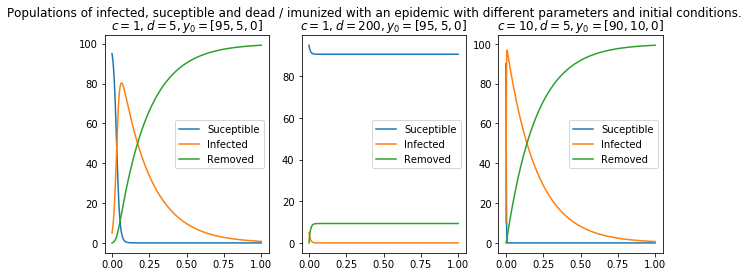

In [45]:
import scipy as sp
import numpy as np
import pylab as plt
import scipy.integrate


def deriv(c, d):
    return lambda Y, t: dY_dt(Y, t, c, d)

def dY_dt(Y, t=0, c=1, d=5):
    return np.array([-c * Y[0] * Y[1],
                     c * Y[0] * Y[1] - d * Y[1],
                     d * Y[1]])


t = np.linspace(0, 1, num=500)
c = 1
d = 5
Y0 = np.array([95, 5, 0])
Y = sp.integrate.odeint(deriv(c, d), Y0, t)

susceptible, infected, removed = Y.T

fig, ax = plt.subplots(1, 3, figsize=(10,4))
print(ax.shape)
ax[0].plot(t, susceptible, label="Suceptible")
ax[0].plot(t, infected, label="infected".capitalize())
ax[0].plot(t, removed, label="removed".capitalize())

ax[0].legend(loc="best")
ax[0].set_title(r"$c=1, d=5, y_0=[ 95, 5,0]$")

# Try factors.
Y0 = np.array([95, 5, 0])
c = 1
d = 200
Y = sp.integrate.odeint(deriv(c, d), Y0, t)

susceptible, infected, removed = Y.T

ax[1].plot(t, susceptible, label="Suceptible")
ax[1].plot(t, infected, label="infected".capitalize())
ax[1].plot(t, removed, label="removed".capitalize())

ax[1].legend(loc="best")
ax[1].set_title(r"$c={}, d={}, y_0=[95, 5, 0]$".format(c, d))


# Try factors.
Y0 = np.array([90, 10, 0])
c = 10
d = 5
Y = sp.integrate.odeint(deriv(c, d), Y0, t)

susceptible, infected, removed = Y.T

ax[2].plot(t, susceptible, label="Suceptible")
ax[2].plot(t, infected, label="infected".capitalize())
ax[2].plot(t, removed, label="removed".capitalize())

ax[2].legend(loc="best")
ax[2].set_title(r"$c={}, d={}, y_0=[90, 10, 0]$".format(c, d))

fig.suptitle("Populations of infected, suceptible and dead / imunized with an epidemic with different parameters and initial conditions.".capitalize())

# Question 9.3
Suppose that we have three chemical
species whose concentrations are denoted by
$y_1 , y_2 , and y_3$ . If the rate of the reaction
$y_1 \rightarrow y_2$ is proportional to $y_1$ , and the rate
of the reaction $y_2 \rightarrow y_3$ is proportional to $y_2$ ,
then the concentrations are governed by the
system of ODEs

$$y_1'=-k_1y_1$$
$$y_2'=k_1y_1-k_2y_2$$
$$y_3'=k_2y_2$$

where $k_1$ and $k_2$ are the rate constants for the
two reactions.
* (a) What is the Jacobian matrix for this ODE system, and what are its eigenvalues? If the rate constants are positive, is this system stable? Under what conditions will the system be stiff?
* (b) Solve the ODE system numerically, assuming initial concentrations $y_1 (0) = y_2 (0) = y_3 (0) = 1$. Take $k_1 = 1$ and experiment with values of $k_2$ of varying magnitude, specifically, $k_2 = 10, 100, and 1000$. For each value of $k_2$ ,solve the system using a Runge-Kutta method,an Adams method, and a method designed for stiff systems, such as a backward differentiation formula. If you use library routines, compare the different methods with respect to their efficiency, as measured by function evaluations or execution time, for a given accuracy. In each instance, integrate the ODE system from $t = 0$ until the solution is approximately in steady state, or until the method is clearly unstable or grossly inefficient.


The Jacobian is easily found analytically:
$$\left\{J_f(t, y)\right\}_{ij}=\delta f_i(t,y)/\delta y_j$$

$$\begin{bmatrix}
    -k_1 & 0 & 0 \\
    k_1 & -k_2 & 0 \\
    0 & k_2 & 0
\end{bmatrix}$$

With eigenvalues $\lambda = \left\{ 0, -k_1, -k_2 \right\}$ therefore given the conditions of the question, this system is neutrally stable. Since we have a zero eigenvalue, any large value of either $k_1$ or $k_2$ will yield a stiff system.

/home/mw/Documents/NUM_METHODS/lib/python3.5/site-packages/scipy/integrate/_ivp/common.py:32: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


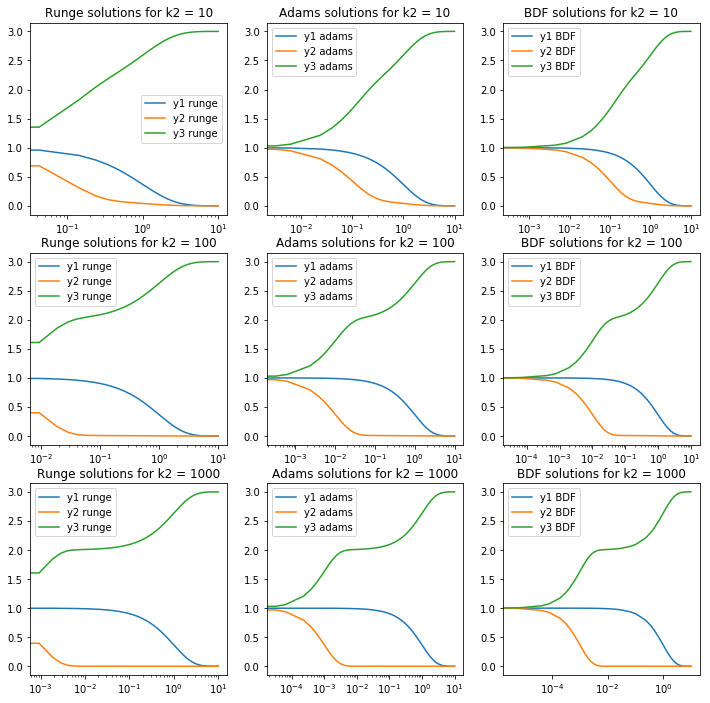

In [86]:
# PART B
import scipy as sp
import numpy as np
import pylab as plt
import scipy.integrate


def deriv(k1, k2):
    return lambda t, Y: dY_dt(Y, t, k1, k2)


def dY_dt(Y, t=0, k1=1, k2=10):
    return np.array([-k1 * Y[0],
                     k1 * Y[0] - k2 * Y[1],
                     k2 * Y[1]])

def jacobian(k1, k2):
    return np.matrix("-{0} 0 0; {0} -{1} 0; 0 {1} 0".format(k1, k2))

deriv(10, 10)

stop = 10
t = np.linspace(0, stop, num=1000)
Y0 = np.array([1, 1, 1])
k1 = 1
k2_ = [10, 100, 1000]
results = []

fig, ax = plt.subplots(3,3, figsize=(12, 12))

for k2, i in zip(k2_, list(range(3))):
    # Runge-Kutta method,an Adams method, and a backward differentiation formula
    runge_kutta = scipy.integrate.solve_ivp(deriv(k1, k2), t_span=(0.0, stop), y0=Y0,
                                            method="RK45", jac=jacobian(k1, k2))
    ax[i, 0].semilogx(runge_kutta.t, runge_kutta.y[0,:], label="y1 runge")
    ax[i, 0].semilogx(runge_kutta.t, runge_kutta.y[1,:], label="y2 runge")
    ax[i, 0].semilogx(runge_kutta.t, runge_kutta.y[2,:], label="y3 runge")
    
    ax[i, 0].legend(loc="best")
    ax[i, 0].set_title("Runge solutions for k2 = {}".format(k2))
    
    # Adams method
    adams = scipy.integrate.solve_ivp(deriv(k1, k2), t_span=(0.0, stop), y0=Y0,
                                            method="LSODA")
    ax[i, 1].semilogx(adams.t, adams.y[0,:], label="y1 adams")
    ax[i, 1].semilogx(adams.t, adams.y[1,:], label="y2 adams")
    ax[i, 1].semilogx(adams.t, adams.y[2,:], label="y3 adams")
    
    ax[i, 1].legend(loc="best")
    ax[i, 1].set_title("Adams solutions for k2 = {}".format(k2))
    
    # Backward diff
    BDF = scipy.integrate.solve_ivp(deriv(k1, k2), t_span=(0.0, stop), y0=Y0,
                                            method="BDF", jac=jacobian(k1, k2))
    ax[i, 2].semilogx(BDF.t, BDF.y[0,:], label="y1 BDF")
    ax[i, 2].semilogx(BDF.t, BDF.y[1,:], label="y2 BDF")
    ax[i, 2].semilogx(BDF.t, BDF.y[2,:], label="y3 BDF")
    
    ax[i, 2].legend(loc="best")
    ax[i, 2].set_title("BDF solutions for k2 = {}".format(k2))
    

# Question 9.7

An important problem in classical mechanics is the motion of two bodies under mutual gravitational attraction. Suppose that a
body of mass m is orbiting a second body of
much larger mass M , such as the earth orbiting
the sun. From Newton’s laws of motion and
gravitation, the orbital trajectory (x(t), y(t))
is described by the system of second-order
ODEs

$$x'' = -GMx/r^3,$$
$$y'' = -GMy/r^3,$$

where G is the gravitational constant and $r =(x^2 +y^2 )^{1/2}$ is the distance of the orbiting body
from the center of mass of the two bodies. For this exercise, we choose units such that GM = 1.


(a)Use a library routine to solve this system of ODEs with the initial conditions $x(0) = 1- e$, $y(0)=0$, $x'(0) =0$, $y'(0)=\left( \frac{1+e}{1-e}\right)^{1/2}, $ where $e$ is the eccentricity of the resulting elliptical orbit, which has period $2\pi$. <span style="color:blue">Try the values e = 0 (which should give a circular orbit), e = 0.5, and e = 0.9. For each case, solve the ODE for at least one period and obtain output at enough intermediate points to draw a smooth plot of the orbital trajectory. <span style="color:red">Make separate plots of x versus t, y versus t, and y versus x. <span style="color:green">Experiment with different error tolerances to see how they affect the cost of the integration and how close the orbit comes to being closed. <span style="color:purple">If you trace the trajectory through several periods, does the orbit tend to wander or remain steady?
    
    
<span style="color:blue">In part one we plot the graphs with different e values. As the e value gets bigger, the overshoot of the elipse neare $2\pi$ becomes much more drastic.

<span style="color:red"> The Distinct plots are shown in the second and third columns.

<span style="color:green"> As the error tolerance goes up we see very erratic behaviour. The extra rows show different different error tolerances.
    
   <span style="color:purple"> The Behaviour of the elipses is directly related to have strict the error is, as well as how small the e value is. When the e values are smaller it behaves better over time. This is shown in the following cell (i.e. I did it seperately with 5 rotations through the elipse.
    

**Part B is in the third cell.**

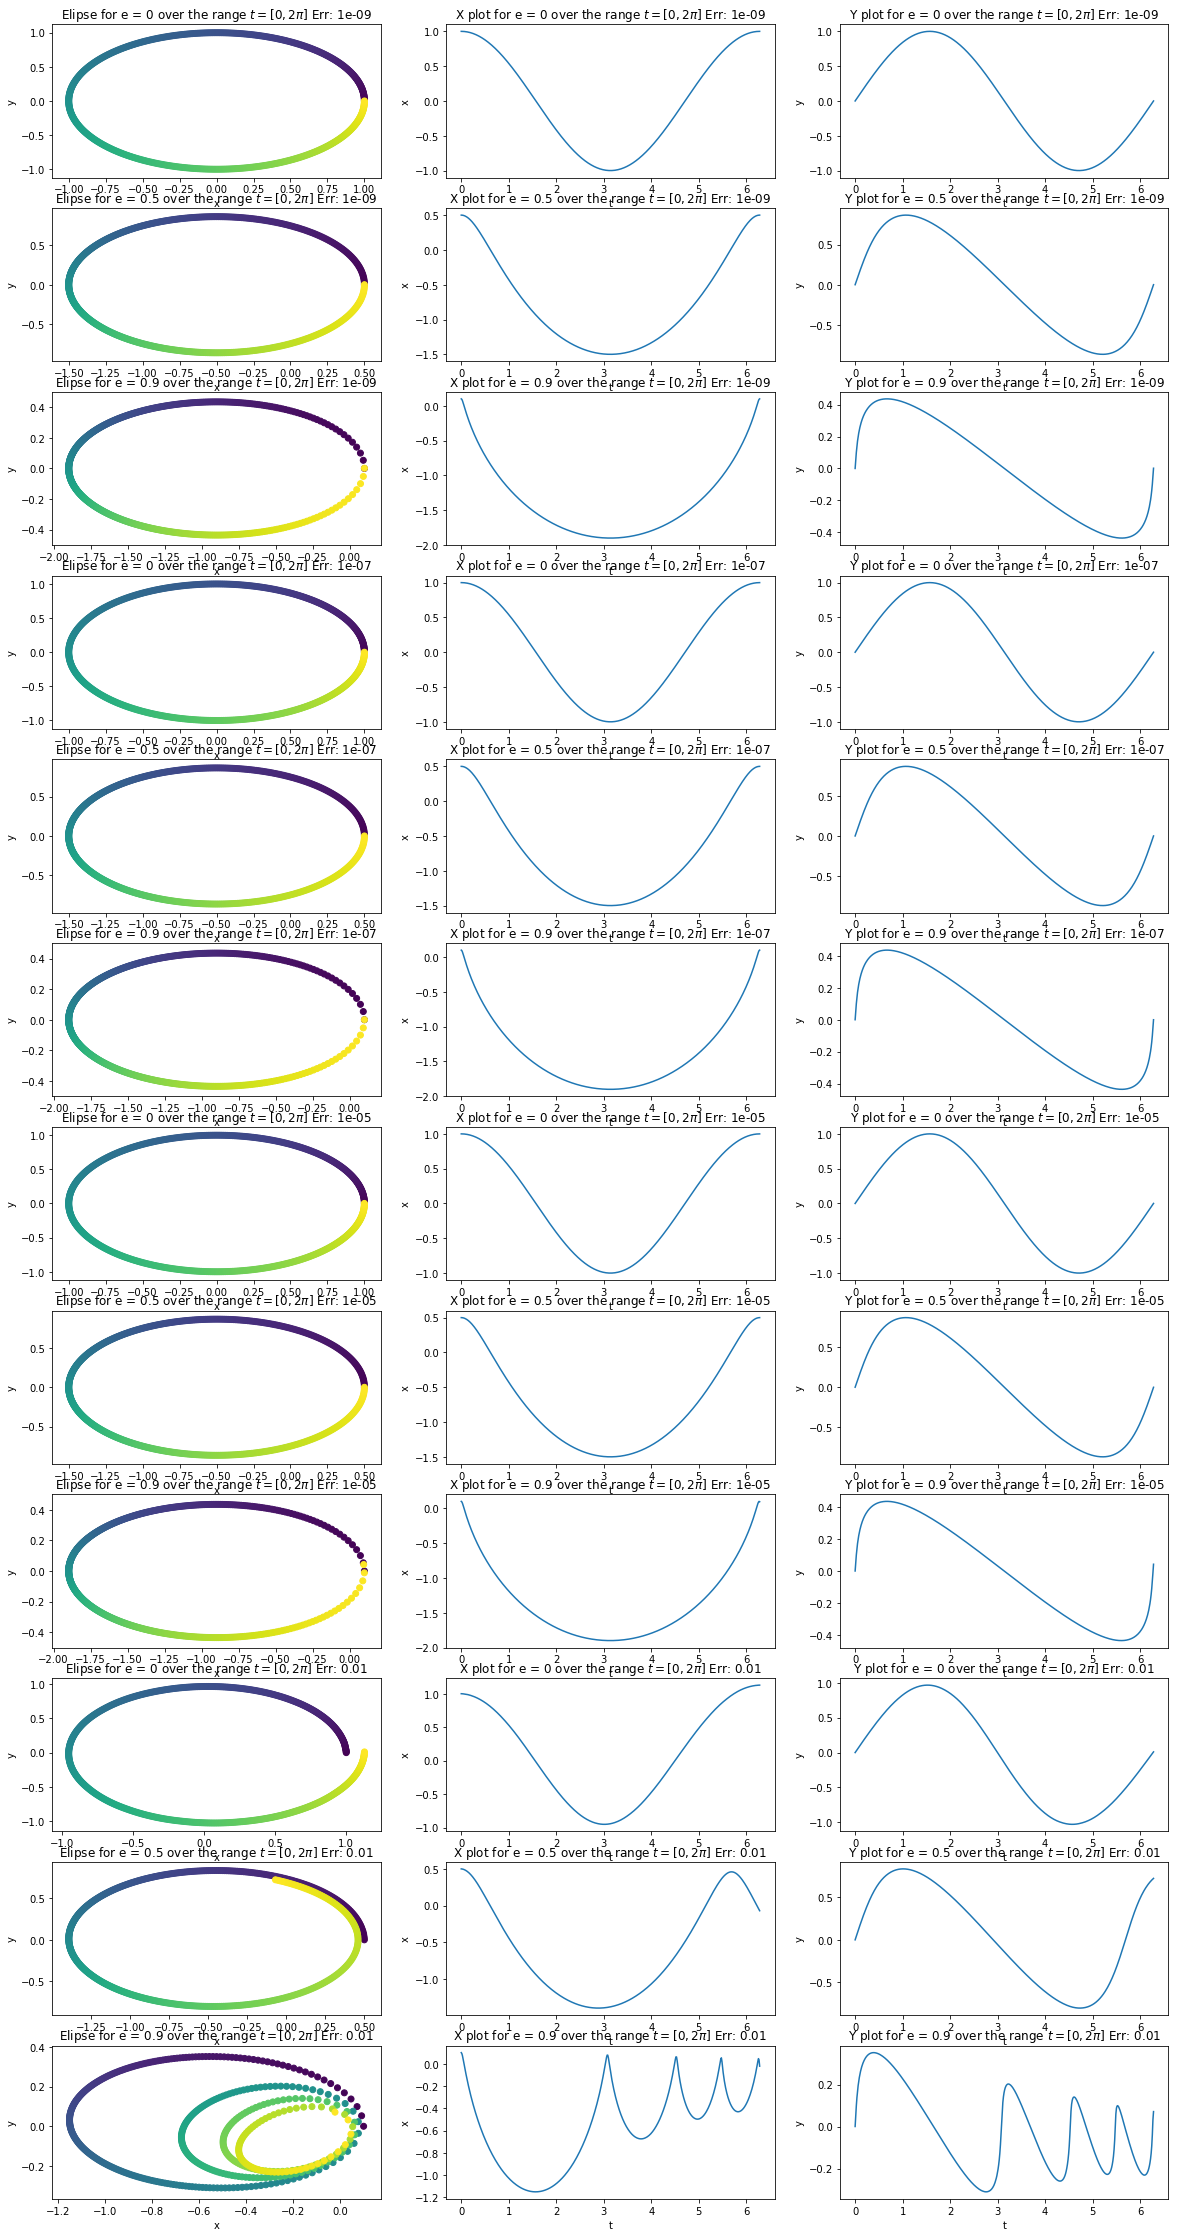

In [174]:
import scipy as sp
import numpy as np
import pylab as plt
import scipy.integrate
import math
import plotly.plotly as py
import plotly.graph_objs as go


def deriv():
    return lambda t, Y: dY_dt(Y, t)


def r(Y):
    return math.sqrt(Y[0]**2 + Y[2]**2)


# Y -> [x, x', y, y']
def dY_dt(Y, t=0):
    return np.array([Y[1],
                     -Y[0]/(r(Y)**3),
                     Y[3],
                     -Y[2]/(r(Y)**3)])


def energy(Y):
    return ((Y[1]**2 + Y[3]**2) / 2) - (1 / r(Y))


def angular_momentum(Y):
    return Y[0] * Y[3] - Y[2] * Y[1]


e_ = [0, 0.5, 0.9]
stop = math.pi * 2.0
t = np.linspace(0, stop, num=500)
error_ = [1e-9, 1e-7, 1e-5, 1e-2]
fig, ax = plt.subplots(len(e_) * len(error_), 3, figsize=(5 * len(error_), 40))

errs_tab = []
e_tab = []
energy_var_tab = []
momen_var_tab = []

for err, j in zip(error_, range(len(error_))):
    for e, k in zip(e_, list(range(len(e_)))):
        Y0 = np.array([1 - e, 0, 0, math.sqrt((1 + e) / (1 - e))])
        res = sp.integrate.solve_ivp(deriv(), t_span=(0, stop), y0=Y0, method="BDF", dense_output=True, rtol=err)
        out = res.sol(t)
        i = j * 3 + k
        ax[i, 0].scatter(out[0,:], out[2,:], c=t)
        ax[i, 0].set_title("Elipse for e = {} over the range $t=[0, 2\pi]$ Err: {}".format(e, err))
        ax[i, 0].set_ylabel("y")
        ax[i, 0].set_xlabel("x")

        ax[i, 1].plot(t, out[0,:])
        ax[i, 1].set_title("X plot for e = {} over the range $t=[0, 2\pi]$ Err: {}".format(e, err))
        ax[i, 1].set_ylabel("x")
        ax[i, 1].set_xlabel("t")

        ax[i, 2].plot(t, out[2,:])
        ax[i, 2].set_title("Y plot for e = {} over the range $t=[0, 2\pi]$ Err: {}".format(e, err))
        ax[i, 2].set_ylabel("y")
        ax[i, 2].set_xlabel("t")
        
        # Calculate the mse from the mean of the energy and angular momentum.
        energies = np.array([energy(y) for y in out.T])
        momentums = np.array([angular_momentum(y) for y in out.T])
        
        errs_tab.append(err)
        e_tab.append(e)
        energy_var_tab.append(energies.var())
        momen_var_tab.append(momentums.var())

errs_tab = np.array(errs_tab)
e_tab = np.array(e_tab)
energy_var_tab = np.array(energy_var_tab)
momen_var_tab = np.array(momen_var_tab)

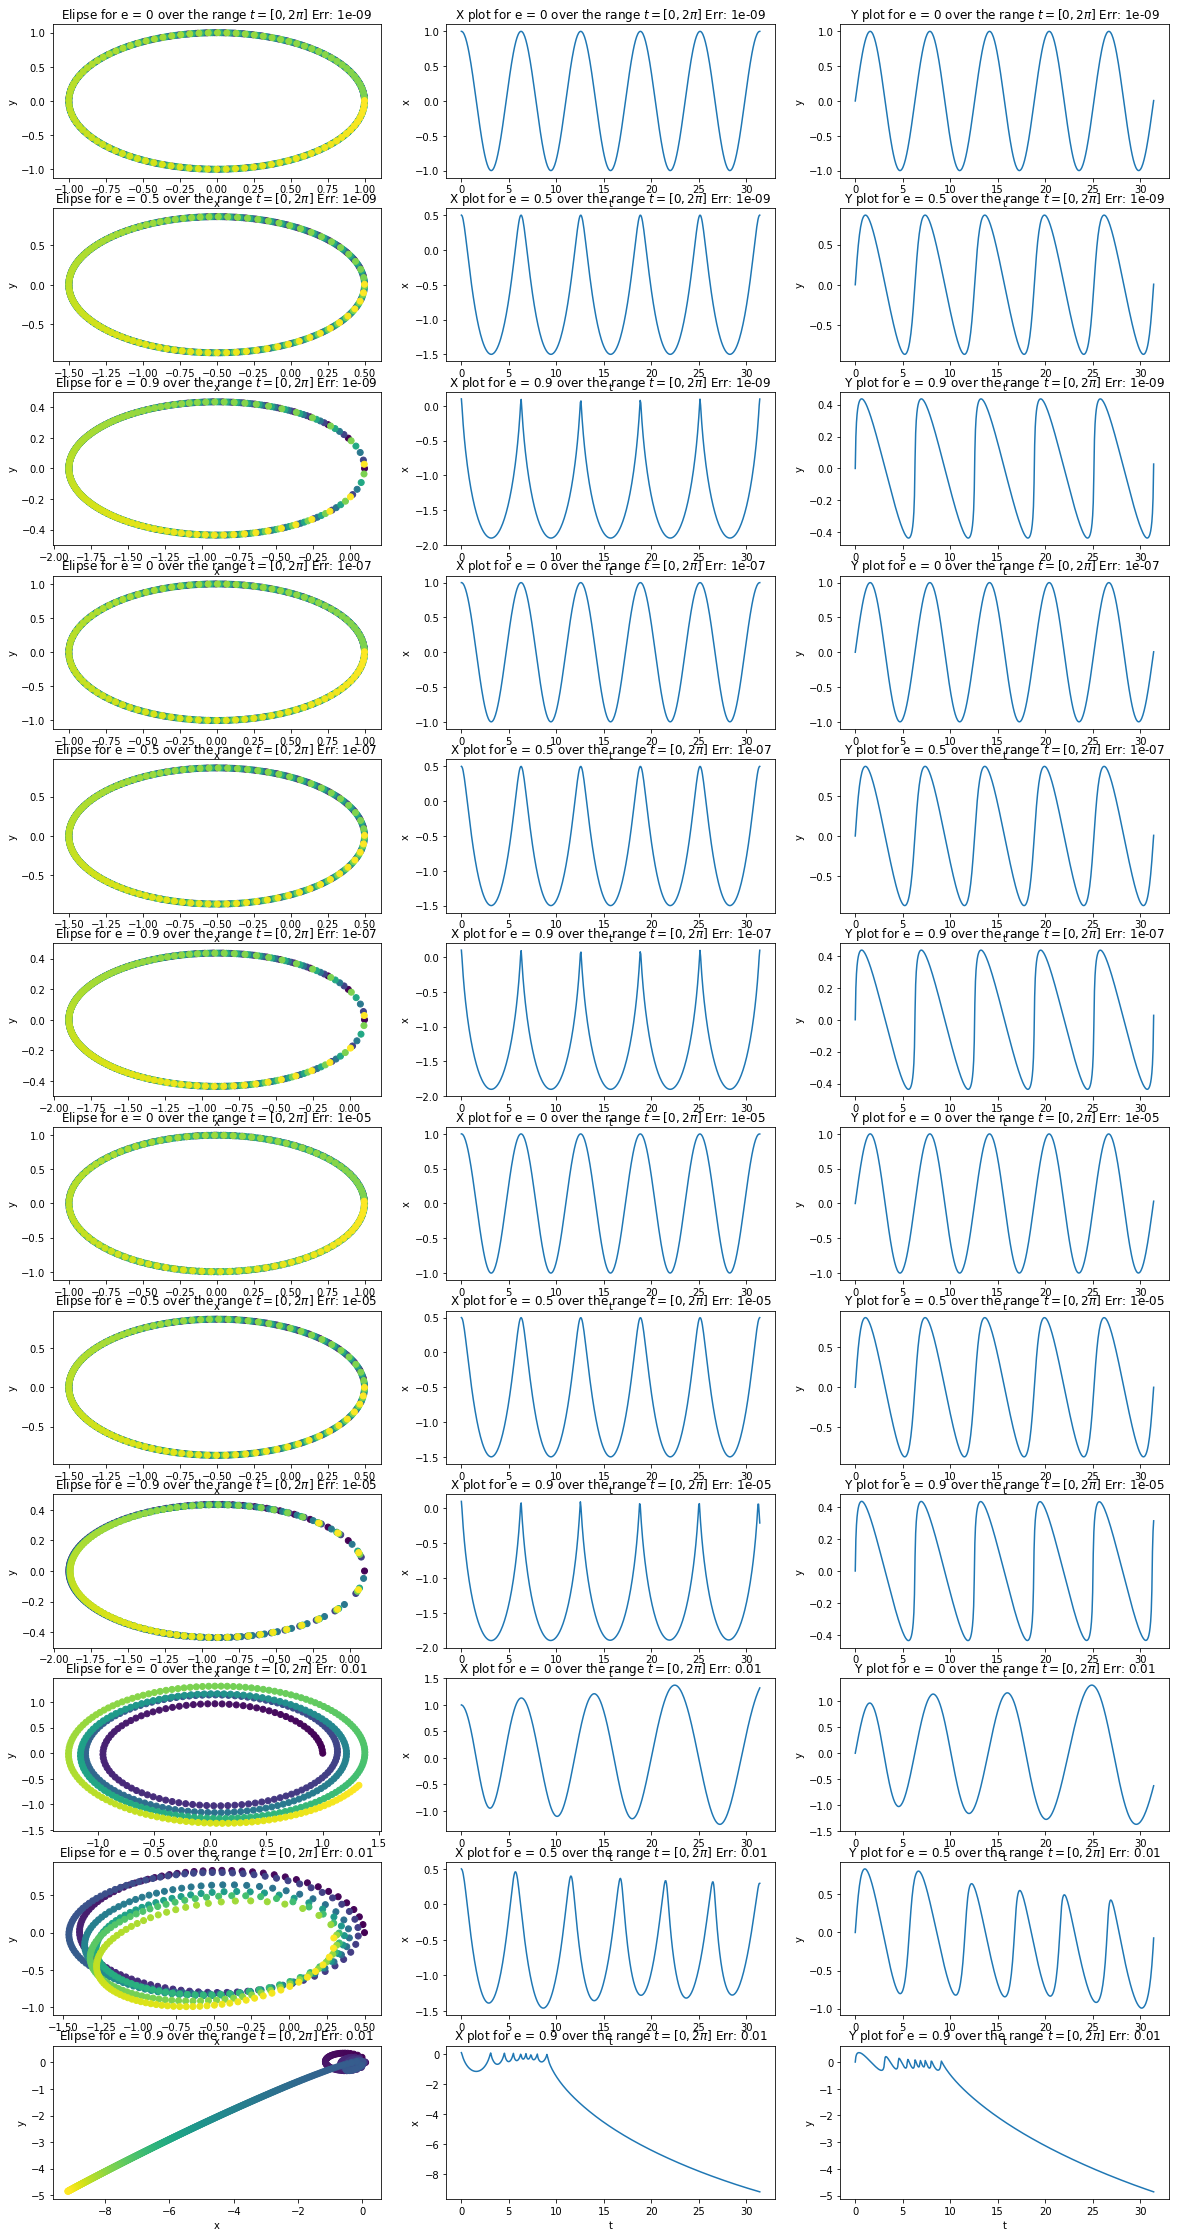

In [151]:
"""Multiple rotations!"""

import scipy as sp
import numpy as np
import pylab as plt
import scipy.integrate
import math


def deriv():
    return lambda t, Y: dY_dt(Y, t)


# Y -> [x, x', y, y']
def dY_dt(Y, t=0):
    r = math.sqrt(Y[0]**2 + Y[2]**2)
    return np.array([Y[1],
                     -Y[0]/(r**3),
                     Y[3],
                     -Y[2]/(r**3)])


e_ = [0, 0.5, 0.9]
stop = math.pi * 10.0
t = np.linspace(0, stop, num=500)
error_ = [1e-9, 1e-7, 1e-5, 1e-2]
fig, ax = plt.subplots(len(e_) * len(error_), 3, figsize=(5 * len(error_), 40))

for err, j in zip(error_, range(len(error_))):
    for e, k in zip(e_, list(range(len(e_)))):
        Y0 = np.array([1 - e, 0, 0, math.sqrt((1 + e) / (1 - e))])
        res = sp.integrate.solve_ivp(deriv(), t_span=(0, stop), y0=Y0, method="BDF", dense_output=True, rtol=err)
        out = res.sol(t)
        i = j * 3 + k
        ax[i, 0].scatter(out[0,:], out[2,:], c=t)
        ax[i, 0].set_title("Elipse for e = {} over the range $t=[0, 2\pi]$ Err: {}".format(e, err))
        ax[i, 0].set_ylabel("y")
        ax[i, 0].set_xlabel("x")

        ax[i, 1].plot(t, out[0,:])
        ax[i, 1].set_title("X plot for e = {} over the range $t=[0, 2\pi]$ Err: {}".format(e, err))
        ax[i, 1].set_ylabel("x")
        ax[i, 1].set_xlabel("t")

        ax[i, 2].plot(t, out[2,:])
        ax[i, 2].set_title("Y plot for e = {} over the range $t=[0, 2\pi]$ Err: {}".format(e, err))
        ax[i, 2].set_ylabel("y")
        ax[i, 2].set_xlabel("t")
    

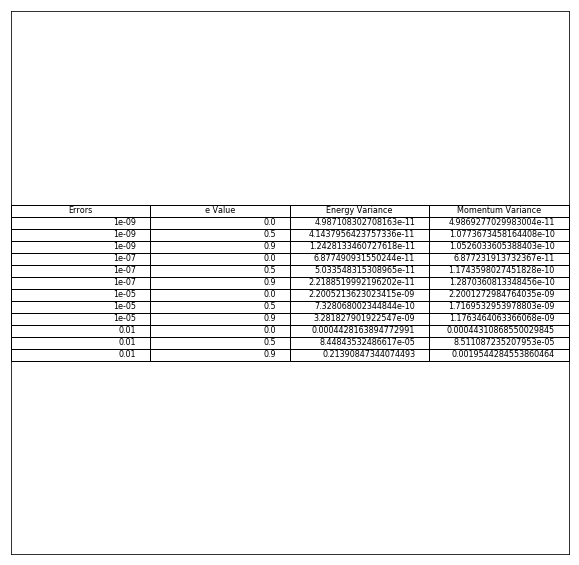

In [178]:
"""Dependent on the 1st cell, so you need to run that before you can run this."""

data  = np.concatenate([[errs_tab], [e_tab], [energy_var_tab], [momen_var_tab]], axis=0)

columns = ("Errors", "e Value", "Energy Variance", "Momentum Variance")

fig, ax = plt.subplots(figsize=(10, 10))
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)

ax.table(cellText=data.T,colLabels=columns,loc='center')

# Question 9.8

I'm going to come back to this question if I have some more time.